# Lead-Acid Models

We compare a standard porous-electrode model for lead-acid batteries with two asymptotic reductions. For a more in-depth introduction to PyBaMM models, see the [SPM notebook](./SPM.ipynb). Further details on the models can be found in [[4]](#References).

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


### "Full" model

#### Electrolyte Concentration

$$
    \frac{\partial }{\partial t}\left(\epsilon c\right) = -\frac{\partial N}{\partial x} + sj, \\ 
    N = -\frac{\epsilon^b  D(c)}{\mathcal{C}_\text{e}}  \frac{\partial c}{\partial x}\\
    N\big|_{x=0}= N\big|_{x=1}=0, \\ 
    c\big|_{t=0} = 1
$$ 

#### Porosity

$$
    \frac{\partial \epsilon}{\partial t} = -\beta^\text{surf}j, \\  
    \epsilon\big|_{t=0} = \epsilon^0
$$ 

#### Electrolyte Current 

$$
    \frac{\partial i_{\text{e}}}{\partial x} = j, \\
    \mathcal{C}_\text{e} i_{\text{e}} = \epsilon_k^b \kappa(c) 
        \left( \chi \frac{\partial}{\partial x}\log(c) 
        - \frac{\partial\phi_{\text{e}}}{\partial x}\right)\\
    i_{\text{e}}\big|_{x=0}= i_{\text{e}}\big|_{x=1}=0,
$$

#### Electrode Current 

$$
    \frac{\partial i_{\text{s}}}{\partial x} = -j,\\
    i_{\text{s}} = -\sigma\frac{\partial\phi_{\text{s}}}{\partial x},\\
    \phi_{\text{s}}\big|_{x=0}
        = i_{\text{s}}\big|_{x=l_\text{n}} 
        = i_{\text{s}}\big|_{x=1-l_\text{p}} = 0, \\
    i_{\text{s}}\big|_{x=1}=\mathcal{I},
$$


#### interfacial current density

$$
j = \begin{cases}
    2j_0(c) \sinh\left(\eta\right), \quad &0 < x < l_\text{n} \\
    0, \quad &l_\text{n} < x < 1-l_\text{p} \\
    2j_0(c) \sinh\left(\eta\right), \quad &1-l_\text{p} < x < 1 
\end{cases}
\\
\eta = \phi_{\text{s}} - \phi_\text{e} - U(c),
$$


This model is implemented in PyBaMM as the `Full` model 

In [2]:
full = pybamm.lead_acid.Full()

### "Leading-order" model 

$$
    \frac{\mathrm{d} }{\mathrm{d} t}\left(\epsilon c\right) = (s_\text{n} - s_\text{p})\mathrm{I}, \\
    \frac{\mathrm{d} \epsilon}{\mathrm{d} t} = -\beta^\text{surf}j, \\
    j = \begin{cases}
        \mathrm{I}/l_\text{n}, \quad &0 < x < l_\text{n} \\
        0, \quad &l_\text{n} < x < 1-l_\text{p} \\
        -\mathrm{I}/l_\text{p}, \quad &1-l_\text{p} < x < 1 
    \end{cases} \\
    \phi_\text{e} = -U_\text{n}(c) + \sinh^{-1}\left(\frac{\mathrm{I}}{2l_\text{n}j_{0\text{n}}(c)}\right) \\
    V = -\phi_\text{e} + U_\text{p}(c) - \sinh^{-1}\left(\frac{\mathrm{I}}{2l_\text{p}j_{0\text{p}}(c)}\right) \\
$$

This model is implemented in PyBaMM as `LOQS` (leading-order quasi-static)

In [3]:
loqs = pybamm.lead_acid.LOQS()

## Solving the models

We load process parameters for each model, using the same set of (default) parameters for all. In anticipation of changing the current later, we make current an input parameter

In [4]:
# load models
models = [loqs, full]

# process parameters
param = models[0].default_parameter_values
param["Current function [A]"] = "[input]"
for model in models:
    param.process_model(model)

Then, we discretise the models, using the default settings

In [5]:
for model in models:
    # load and process default geometry
    geometry = model.default_geometry
    param.process_geometry(geometry)
    
    # discretise using default settings
    mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)
    disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
    disc.process_model(model)

Finally, we solve each model using CasADi's solver and a current of 1A

In [6]:
timer = pybamm.Timer()
solutions = {}
t_eval = np.linspace(0, 3600 * 17, 100) # time in seconds
solver = pybamm.CasadiSolver()
for model in models:
    timer.reset()
    solution = solver.solve(model, t_eval, inputs={"Current function [A]": 1})
    print("Solved the {} in {}".format(model.name, timer.time()))
    solutions[model] = solution

Solved the LOQS model in 46.545 ms
Solved the Full model in 833.591 ms


## Results

To plot the results, the variables are extracted from the solutions dictionary. For example, we can compare the voltages:

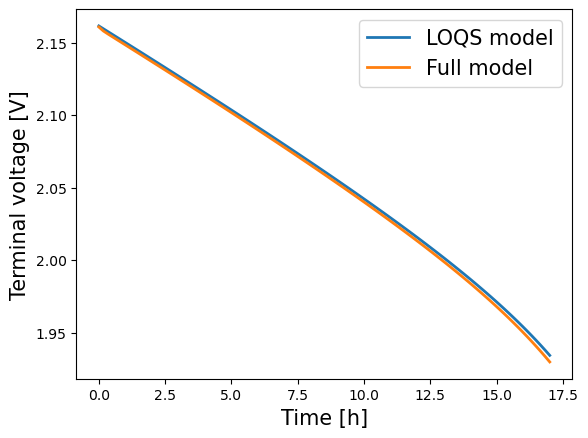

In [7]:
for model in models:
    time = solutions[model]["Time [h]"].entries
    voltage = solutions[model]["Terminal voltage [V]"].entries
    plt.plot(time, voltage, lw=2, label=model.name)
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Alternatively, using `QuickPlot`, we can compare the values of some variables

In [8]:
solution_values = [solutions[model] for model in models]
quick_plot = pybamm.QuickPlot(solution_values)
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=17.0, step=0.17), Output()), _dom_classes=('…

If we update the current, setting it to be 20 A, we observe a greater discrepancy between the full model and the reduced-order models.

In [9]:
t_eval = np.linspace(0, 3600, 100)
for model in models:
    solutions[model] = solver.solve(model, t_eval, inputs={"Current function [A]": 20})

# Plot
solution_values = [solutions[model] for model in models]
quick_plot = pybamm.QuickPlot(solution_values)
quick_plot.dynamic_plot();

At t = 0.0087774 and h = 2.16761e-39, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00384476 and h = 3.51822e-38, the corrector convergence failed repeatedly or with |h| = hmin.


interactive(children=(FloatSlider(value=0.0, description='t', max=3415.761176654425, step=34.15761176654425), …

## References

The relevant papers for this notebook are:

In [10]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Valentin Sulzer, S. Jon Chapman, Colin P. Please, David A. Howey, and Charles W. Monroe. Faster Lead-Acid Battery Simulations from Porous-Electrode Theory: Part I. Physical Model. Journal of The Electrochemical Society, 166(12):A2363–A2371, 2019. doi:10.1149/2.0301910jes.
[4] Valentin Sulzer, S. Jon Chapman, Colin P. Please, David A. Howey, and Charles W. Monroe. Faster Lead-Acid Battery Simulations from Porous-Electrode Theory: Part II. Asymptotic Analys